Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [37]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [38]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.
It's a 100MB of text file with ~17 million separate words.

In [39]:
def read_data(filename):
  f = zipfile.ZipFile(filename)
  for name in f.namelist():
    return tf.compat.as_str(f.read(name)).split()
  f.close()
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [40]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
print('Reverse dict', list(reverse_dictionary[d] for d in data[:10]))
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]
Reverse dict ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


Function to generate a training batch for the skip-gram model.

In [43]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'originated', 'term', 'anarchism', 'as', 'of', 'originated', 'term']


Train a skip-gram model.

In [44]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [45]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.007317
Nearest to seven: dayan, ean, professes, interactivity, revive, mystics, alluded, strayed,
Nearest to after: minix, begins, functor, invades, slower, hindustan, denmark, socialists,
Nearest to first: slovene, franchisees, effect, therapy, offence, nba, authored, goldman,
Nearest to can: walser, uptime, liquidity, polg, otranto, homophonic, hom, utilised,
Nearest to state: intruding, lawmaking, hittite, islamist, shielding, consilience, orwell, haley,
Nearest to zero: shikoku, anacreon, vessel, neumann, gem, reinstating, reassert, manages,
Nearest to about: yahweh, temptation, appalachian, depressants, anthems, redundantly, merrill, dune,
Nearest to not: warlike, jaya, attributed, chukchi, cries, webzine, indecision, ule,
Nearest to that: health, mol, importing, illegality, epicycle, hingis, vanquished, andriessen,
Nearest to been: graphene, detainee, rrna, vowel, upheavals, pda, keeping, boycotted,
Nearest to was: pray, neologism, johannesbu

In [47]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

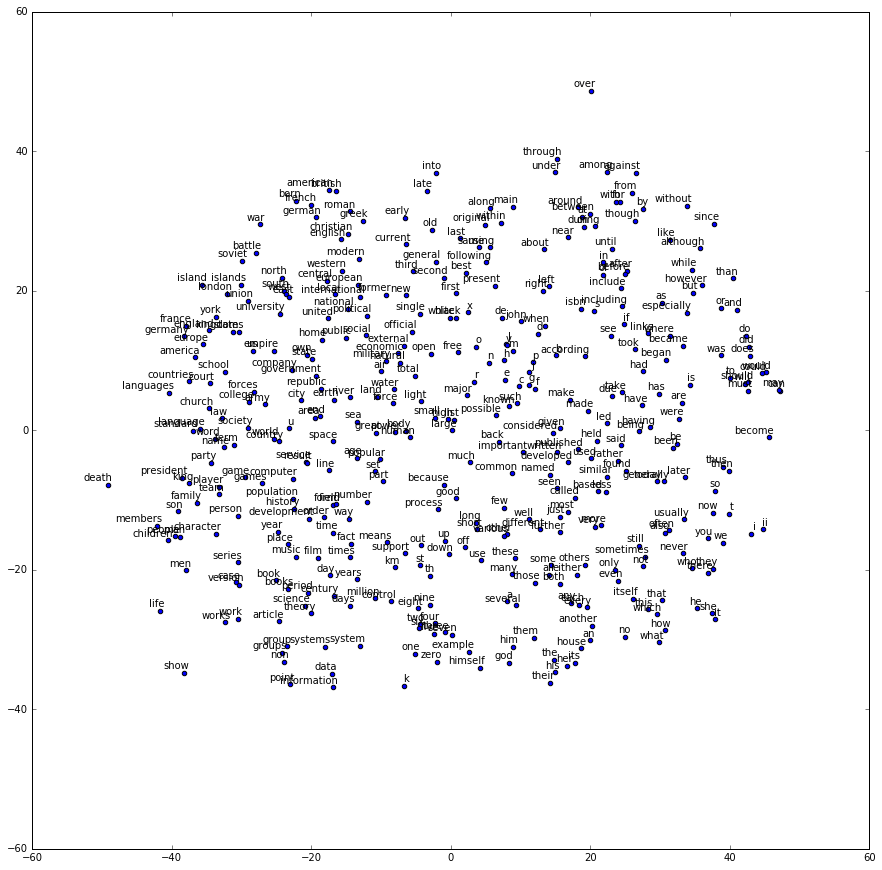

In [48]:
%matplotlib inline

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to Skip-gram is called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [52]:
# For CBOW we switch batch output and context label:

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    # NEW: switch batch and labels around!
    # batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    labels, batch = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    # NEW: reshaping needs to happen with batch now as that is a (batch_size,1) vector
    #print('    batch:', [reverse_dictionary[bi] for bi in batch])
    #print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
    print('    batch:', [reverse_dictionary[bi] for bi in batch.reshape(8)])
    print('    labels:', [reverse_dictionary[li] for li in labels])


with num_skips = 2 and skip_window = 1:
    batch: ['as', 'anarchism', 'a', 'originated', 'term', 'as', 'a', 'of']
    labels: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']

with num_skips = 4 and skip_window = 2:
    batch: ['originated', 'term', 'a', 'anarchism', 'originated', 'term', 'as', 'of']
    labels: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']


In [54]:
batch_size = 128
num_skips = 2
skip_window = 1

num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    # NEW: Need to explicitly reshape dataset and labels following above switch:
    #feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    feed_dict = {train_dataset : batch_data.reshape(batch_size), train_labels : batch_labels.reshape(batch_size, 1)}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.077976
Nearest to seven: cimbri, class, cats, sheaf, amit, angelica, michaux, jia,
Nearest to after: humorists, eventual, weighed, radiotelephone, operated, jungles, dai, supernovae,
Nearest to first: safavid, terminal, openness, sailboat, aulus, rests, medulla, emperors,
Nearest to can: disclaimer, rollo, genes, israelis, weasel, toads, angels, methodists,
Nearest to state: composer, warcraft, npd, goodbye, handwritten, patsy, galois, artform,
Nearest to zero: citizen, flocked, rcaf, compensatory, dangers, probability, cade, teborg,
Nearest to about: arexx, suppressing, dances, svc, macdonald, satisfying, wright, marco,
Nearest to not: peacetime, criticized, deputies, erection, jahn, psychic, madame, counterrevolutionary,
Nearest to that: zach, responding, melancholic, aliases, dilemma, archibald, commander, flick,
Nearest to been: warren, mehr, mexicana, talks, abbreviate, ich, banister, storm,
Nearest to was: paddy, poetically, dicke, farrell, g

In [55]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

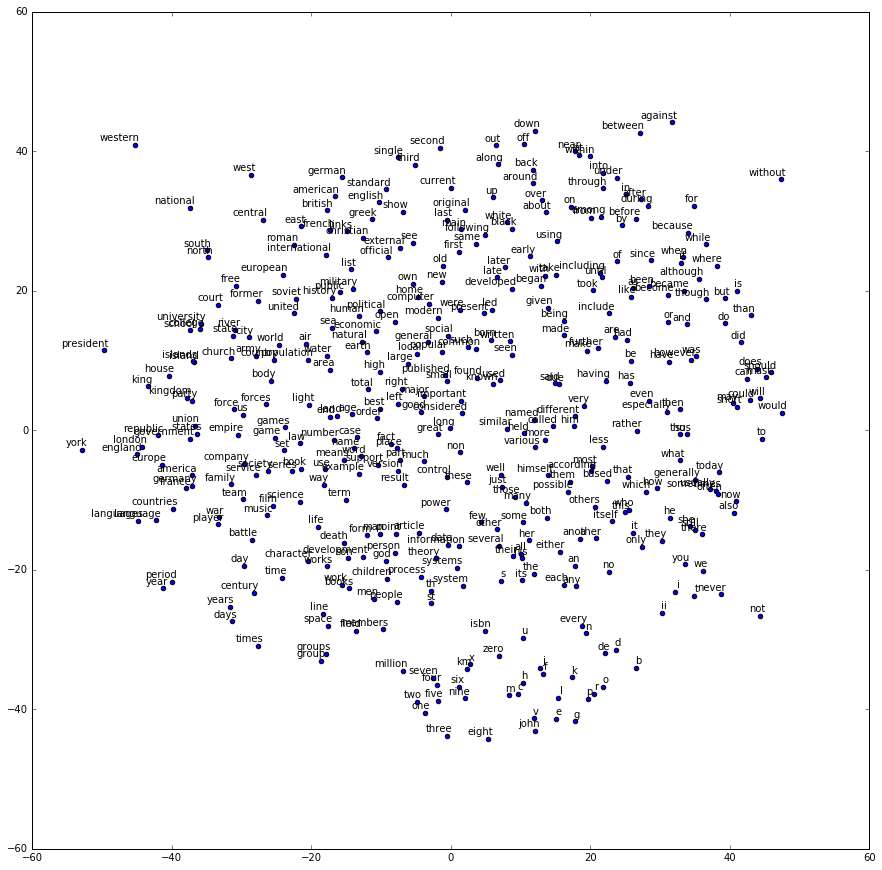

In [56]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

## Additional notes

### 1. word2vec training batch generation

Closer look at batch handling.  We generate a batch_size worth of training samples.  With ```num_skips``` set to 2 this means we repeat each input in output batch.  The data starts with the sentence _"anarchism originated as a term of abuse"_.  On running generate_batch with ```skip_window``` of 1 and ```num_skips``` 2, we will get the standard **word2vec model** where _label_ shows context word (left,right) associated with _batch output_ word as follows:

```
batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
labels: ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'a', 'of']
```


In [49]:
batch_size = 8
num_skips = 2
skip_window = 1
data_index = 0
for i in range(5):
    print("--- minibatch %d ---" % i)
    print('data_index',data_index)
    batch, labels = generate_batch(batch_size, num_skips, skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (2, 1))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

--- minibatch 0 ---
data_index 0

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'a', 'of']
--- minibatch 1 ---
data_index 7

with num_skips = 2 and skip_window = 1:
    batch: ['used', 'used', 'against', 'against', 'early', 'early', 'working', 'working']
    labels: ['first', 'against', 'early', 'used', 'against', 'working', 'early', 'class']
--- minibatch 2 ---
data_index 14

with num_skips = 2 and skip_window = 1:
    batch: ['the', 'the', 'diggers', 'diggers', 'of', 'of', 'the', 'the']
    labels: ['including', 'diggers', 'the', 'of', 'the', 'diggers', 'english', 'of']
--- minibatch 3 ---
data_index 21

with num_skips = 2 and skip_window = 1:
    batch: ['the', 'the', 'sans', 'sans', 'UNK', 'UNK', 'of', 'of']
    labels: ['sans', 'and', 'UNK', 'the', 'sans', 'of', 'the', 'UNK']
--- minibatch 4 ---
data_index 28

with num_skips = 2 and skip_window =

### 2. CBOW training batch generation

For **CBOW (continuous bag of words)** model, we switch output and context (label) so now our _label_ shows the word that corresponds to a particular _output context_:

In [50]:
batch_size = 8
num_skips = 2
skip_window = 1
data_index = 0
for i in range(5):
    print("--- minibatch %d ---" % i)
    print('data_index',data_index)
    labels, batch = generate_batch(batch_size, num_skips, skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (2, 1))
    print('    batch:', [reverse_dictionary[bi] for bi in batch.reshape(8)])
    print('    labels:', [reverse_dictionary[li] for li in labels])

--- minibatch 0 ---
data_index 0

with num_skips = 2 and skip_window = 1:
    batch: ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'a', 'of']
    labels: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
--- minibatch 1 ---
data_index 7

with num_skips = 2 and skip_window = 1:
    batch: ['against', 'first', 'early', 'used', 'working', 'against', 'class', 'early']
    labels: ['used', 'used', 'against', 'against', 'early', 'early', 'working', 'working']
--- minibatch 2 ---
data_index 14

with num_skips = 2 and skip_window = 1:
    batch: ['diggers', 'including', 'of', 'the', 'diggers', 'the', 'of', 'english']
    labels: ['the', 'the', 'diggers', 'diggers', 'of', 'of', 'the', 'the']
--- minibatch 3 ---
data_index 21

with num_skips = 2 and skip_window = 1:
    batch: ['and', 'sans', 'UNK', 'the', 'of', 'sans', 'the', 'UNK']
    labels: ['the', 'the', 'sans', 'sans', 'UNK', 'UNK', 'of', 'of']
--- minibatch 4 ---
data_index 28

with num_skips = 2 and skip_window =

### 3. valid_examples

Final note: ```valid_examples``` should give you an array of 16 random indices of common words (all less that 100):

In [51]:
print(valid_examples)
print([reverse_dictionary[ex] for ex in valid_examples])

[23 61 46 53 94  8 79 38 20 54 18 86 24 65 83 78]
['seven', 'after', 'first', 'can', 'state', 'zero', 'about', 'not', 'that', 'been', 'was', 'united', 'with', 'time', 'people', 'between']
